# Build waver

## Inputs

In [69]:
input_file = '../testdata/poseidon.mp3'

heart_rate_hz = 60 # framerate of the vizualizer in Hz
box_groups = 30 # number of boxes for vizualizer

image_height = 100 # height of the vizualizer in pixels
bit_width = 10 # width of each box in pixels
bg_color = (0, 0, 255) # background color
fg_color = (0, 0, 128) # foreground color

In [70]:
# calculated values
wav_file = input_file.replace('.mp3', '.wav')
vis_file = input_file.replace('.mp3', '_vis.mp4')
combined_file = input_file.replace('.mp3', '.mp4')
image_width = bit_width * box_groups

## Imports

In [71]:
from PIL import Image, ImageDraw
import imageio
import subprocess
import wave
import numpy as np
from scipy.fftpack import fft
from matplotlib import pyplot as plt
import math

## Build WAV file

In [72]:
def convert_mp3_to_wav(input_file, output_file):
    command = ['ffmpeg', '-y', '-i', input_file, output_file]
    subprocess.run(command)

convert_mp3_to_wav(input_file, wav_file)

## Analyse WAV

In [73]:
w = wave.open(wav_file, 'rb')

In [74]:
framerate = w.getframerate()
frame_count = w.getnframes()
channels = w.getnchannels()
sampwidth = w.getsampwidth()
first_frame = w.readframes(1)
cursor_position = w.tell()
w.setpos(0) # reset cursor position
cursor_position_after_reset = w.tell()

print(f'framerate: {framerate}')
print(f'frame_count: {frame_count}')
print(f'channels: {channels}')
print(f'sampwidth: {sampwidth}')
print(f'first_frame: {first_frame}')
print(f'cursor_position: {cursor_position}')
print(f'cursor_position_after_reset: {cursor_position_after_reset}')

framerate: 48000
frame_count: 10022662
channels: 2
sampwidth: 2
first_frame: b'\x00\x00\x00\x00'
cursor_position: 1
cursor_position_after_reset: 0


In [75]:
def get_frequencies(w:wave.Wave_read, chunk:int, channels:int, sampwidth:int, frame_pos:int):
    if chunk > frame_pos:
        chunk = frame_pos
    w.setpos(frame_pos - chunk)
    frames = w.readframes(chunk)
    frames = np.frombuffer(frames, dtype=np.int16)
    frames = frames.reshape((chunk, channels))
    channel_freqs = []
    for i in range(channels):
        channel_frames = frames[:, i]
        channel_fft = fft(channel_frames)
        normed_channel_fft = np.abs(channel_fft[0:chunk]) / chunk / 256 / 2
        channel_freqs.append(normed_channel_fft)
    return sum(channel_freqs) / channels

In [79]:
freqs = []
raw_freqs = []
box_root = (framerate / 2) ** (1 / box_groups)
for i in range(0, frame_count, framerate // heart_rate_hz):
    try:
        freq = get_frequencies(w, framerate, channels, sampwidth, i)
        raw_freqs.append(freq)
        sampled_freqs = []
        for i in range(0, box_groups):
            lower_bound = int(box_root**i) + 20
            upper_bound = int(box_root**(i+1)) + 20
            if upper_bound > len(freq):
                upper_bound = len(freq)
            if lower_bound > len(freq):
                sampled_freqs.append(0)
                continue
            if lower_bound == upper_bound:
                lower_bound -= 1
            sampled_freqs.append(max(freq[lower_bound:upper_bound]))
        freqs.append(sampled_freqs)
    except Exception as ex:
        print(f'{lower_bound=} {upper_bound=} {ex=}')
        raw_freqs.append(None)
        freqs.append([0]*box_groups)

lower_bound=21 upper_bound=21 ex=ValueError('invalid number of data points (0) specified')


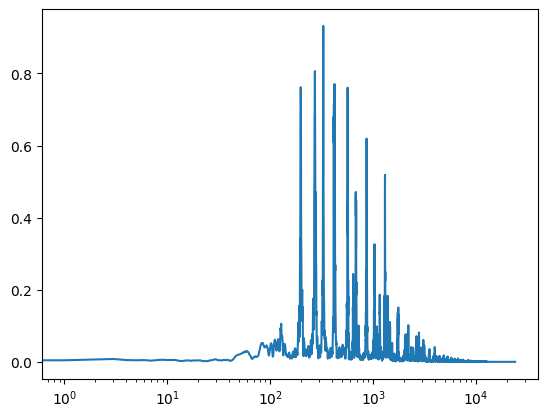

In [80]:
plt.semilogx(raw_freqs[400][20:framerate//2])

In [83]:
w.close()

## Build mp4

In [81]:
image_frames = []
for frame in freqs:
    im = Image.new('RGB', (image_width, image_height), bg_color)
    draw = ImageDraw.Draw(im)
    for i, bit in enumerate(frame):
        top_border = image_height - image_height*bit
        if top_border < 0:
            top_border = 0
        draw.rectangle([i*bit_width, top_border, (i+1)*bit_width, image_height], fill=fg_color)
    image_frames.append(im)

imageio.mimsave(vis_file, image_frames, fps=heart_rate_hz)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 100) to (304, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Combine audio and video

In [82]:
import subprocess

def combine_audio_video(audio_file, video_file, output_file):
    command = ['ffmpeg', '-y', '-i', audio_file, '-i', video_file, '-c:v', 'copy', '-c:a', 'aac', output_file]
    subprocess.run(command)

# Usage example
audio_file = input_file
video_file = vis_file
output_file = combined_file
combine_audio_video(audio_file, video_file, output_file)